# Valeo case study

**Disclaimer:**

This colabs is my first attempt to implement machine learning tools on a real dataset.

I may not use the state of the art methodology and I'm fine with it as my main purpose is to try, learn an uderstand. Feel free to point out any mistake or inconsistency in my try

toto dmfkjqsdmfjqdsf

# Library & utilities

In [1]:
# pandas stuff
import pandas as pd

# sklearn stuff
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#Datasets import

In [26]:
# for convenience purpose the data file is stored in my personal onedrive
# For an unknown raison pd.read_csv from this url doesn't work
#url="https://1drv.ms/x/s!Amyq3hD1jCNbipZprCZXqQDc-dG_7g?e=pQETPs"
csv_file="Dataset_pour_workshop.csv"

#this dataframe will contain raw data from valeo
valeo_data=pd.read_csv(csv_file)

#this dataframe will contain all modifications
sandbox_data=valeo_data.copy()

#Data exploration & feature engineering

## PROC_TRACEINFO feature

In [27]:
len(sandbox_data["PROC_TRACEINFO"].unique())

42516

All entries from "PROC_TRACEINFO" are unique!

In [28]:
print(sandbox_data["PROC_TRACEINFO"].iloc[0])

I-B-XA1207672-190429-00688


Entries from PROC_TRACEINFO are composed from 3 parts:

* I-B-XA1207672 ref of the product
* 190429 date of the operation format (YYMMDD)
* ID of the product increment every 12s

In [29]:
re_patern=r'^([a-zA-Z]{1}-[a-zA-Z]{1}-[a-zA-Z]{2}\d{7})-(\d{2}\d{2}\d{2})-(\d+)$'

sandbox_data[["_reference","_date","_serial"]]=sandbox_data["PROC_TRACEINFO"].str.extract(re_patern)
sandbox_data.head(3)

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar_OP130_Resultat_Global_v,_reference,_date,_serial
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60,1,I-B-XA1207672,190429,00688
1,I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,1,I-B-XA1207672,190828,00973
2,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61,1,I-B-XA1207672,190712,03462


In [30]:
sandbox_data["_reference"].value_counts()

,count
_reference,
I-B-XA1207672,42516


All entries have the same product "I-B-XA1207672" reference.

we won't extract any additional information from this => this feature (*_reference*) can be drop on all rows

In [33]:
sandbox_data['_date']=pd.to_datetime(sandbox_data['_date'], format='%y%m%d')

In [37]:
sandbox_data['_day']=sandbox_data['_date'].dt.day_of_week
sandbox_data['_month']=sandbox_data['_date'].dt.month
sandbox_data.head()

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar_OP130_Resultat_Global_v,_reference,_date,_serial,_day,_month
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60,1,I-B-XA1207672,2019-04-29,00688,0,4
1,I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,1,I-B-XA1207672,2019-08-28,00973,2,8
2,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61,1,I-B-XA1207672,2019-07-12,03462,4,7
3,I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61,1,I-B-XA1207672,2019-08-03,00051,5,8
4,I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,NaN,11.97,6.62,29.22,33.6,99.19,6.61,1,I-B-XA1207672,2019-05-08,03248,2,5


# Machine learning modelisation

## Naive gaussian bayes

In [18]:
#ToDo: a intégrer la suppression des columns dans le pipeline
target='Binar_OP130_Resultat_Global_v'
features_to_drop=['PROC_TRACEINFO','OP100_Capuchon_insertion_mesure', '_reference', target ]

X=sandbox_data
y=sandbox_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', features_to_drop),
        #('fill_missing_value', SimpleImputer(strategy='mean'), ['OP100_Capuchon_insertion_mesure']),
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [20]:
pipeline = Pipeline([
    ('data_preparation', preprocessor),
    ('scaler', StandardScaler()),
    ("model", GaussianNB()  )
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preparation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['PROC_TRACEINFO',
                                                   'OP100_Capuchon_insertion_mesure',
                                                   '_reference',
                                                   'Binar_OP130_Resultat_Global_v'])])),
                ('scaler', StandardScaler()), ('model', GaussianNB())])

In [21]:
y_pred=pipeline.predict(X_test)

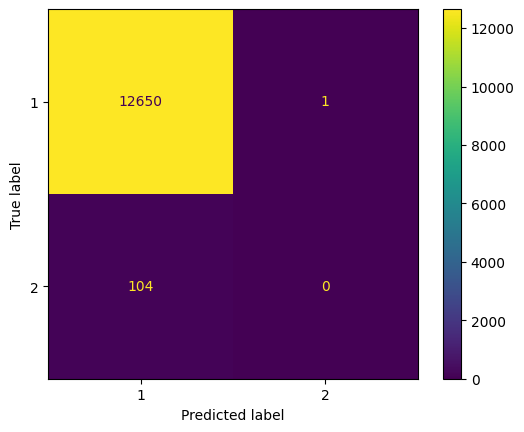

In [22]:
# no use for f1 score for the moment
# print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2])
cm_display.plot()